### Data analysis of hospital admissions in Australia

In [5]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go
import plotly.io as pio
import matplotlib.pyplot as plt
import seaborn as sns 

from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
import statsmodels
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [6]:
df= pd.read_excel('myhosp-patient-admission-data-only.xlsx')

In [7]:
df.head()

,Reporting unit,Reporting unit type,State,Time period,Category,Number of patient admissions
0,Adolescent and Young Adult Hospice Manly,Hospital,NSW,2022–23,Childbirth,0
1,Adolescent and Young Adult Hospice Manly,Hospital,NSW,2022–23,Medical (emergency),0
2,Adolescent and Young Adult Hospice Manly,Hospital,NSW,2022–23,Medical (non-emergency),<5
3,Adolescent and Young Adult Hospice Manly,Hospital,NSW,2022–23,Mental health,0
4,Adolescent and Young Adult Hospice Manly,Hospital,NSW,2022–23,Other acute (emergency),0


In [8]:
df.shape

(103067, 6)

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103067 entries, 0 to 103066
Data columns (total 6 columns):
 #   Column                        Non-Null Count   Dtype 
---  ------                        --------------   ----- 
 0   Reporting unit                103067 non-null  object
 1   Reporting unit type           103067 non-null  object
 2   State                         103067 non-null  object
 3   Time period                   103067 non-null  object
 4   Category                      103067 non-null  object
 5   Number of patient admissions  103067 non-null  object
dtypes: object(6)
memory usage: 4.7+ MB


In [10]:
df['Reporting unit'].nunique()

806

In [11]:
#there are 806 hospitals in total

In [12]:
df['Reporting unit type'].unique()

array(['Hospital', 'Local Hospital Network'], dtype=object)

In [13]:
df['State'].unique()

array(['NSW', 'Vic', 'Qld', 'SA', 'WA', 'Tas', 'NT', 'ACT'], dtype=object)

In [14]:
#All states and territories in Australia are included

In [15]:
df['Time period'].unique()

array(['2022–23', '2011–12', '2012–13', '2013–14', '2014–15', '2015–16',
       '2016–17', '2017–18', '2018–19', '2019–20', '2020–21', '2021–22'],
      dtype=object)

In [16]:
#Data ranges from 2011 to 2023

In [17]:
df['Category'].unique()

array(['Childbirth', 'Medical (emergency)', 'Medical (non-emergency)',
       'Mental health', 'Other acute (emergency)',
       'Other acute (non-emergency)', 'Other subacute and non-acute',
       'Palliative', 'Rehabilitation', 'Surgical (emergency)',
       'Surgical (non-emergency)', 'Total'], dtype=object)

In [18]:
df['Number of patient admissions'].unique()

array([0, '<5', 27, ..., 91603, 91361, 94416], dtype=object)

In [19]:
# '<5' In the data notes it states that:   
# "If an admissions count is less than five but greater than zero the value is marked as '<5' and is excluded from the total count."
# As I am interested in analysing patterns and distributions: I will drop rows with <5, as this will help me focus on more significant data.

In [20]:
df = df[df['Number of patient admissions'] != '<5']

In [21]:
df['Number of patient admissions'].unique()

array([0, 27, 28, ..., 91603, 91361, 94416], dtype=object)

In [22]:
df.shape

(94747, 6)

In [23]:
103067 - 94747

8320

In [24]:
#8320 rows of data were dropped, about 8% of the raw data

In [25]:
df['Number of patient admissions'] = df['Number of patient admissions'].astype(int)

In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 94747 entries, 0 to 103066
Data columns (total 6 columns):
 #   Column                        Non-Null Count  Dtype 
---  ------                        --------------  ----- 
 0   Reporting unit                94747 non-null  object
 1   Reporting unit type           94747 non-null  object
 2   State                         94747 non-null  object
 3   Time period                   94747 non-null  object
 4   Category                      94747 non-null  object
 5   Number of patient admissions  94747 non-null  int32 
dtypes: int32(1), object(5)
memory usage: 4.7+ MB


In [27]:
#Check for duplicates

In [28]:
len(df)

94747

In [29]:
df.drop_duplicates(keep= 'first', inplace=True) 

In [30]:
len(df)

94747

In [31]:
#No duplicates found

In [32]:
#Quick snapshot of patient admission data
df['Number of patient admissions'].describe()

count     94747.000000
mean       2046.935618
std        8035.523002
min           0.000000
25%           0.000000
50%          27.000000
75%         624.000000
max      168012.000000
Name: Number of patient admissions, dtype: float64

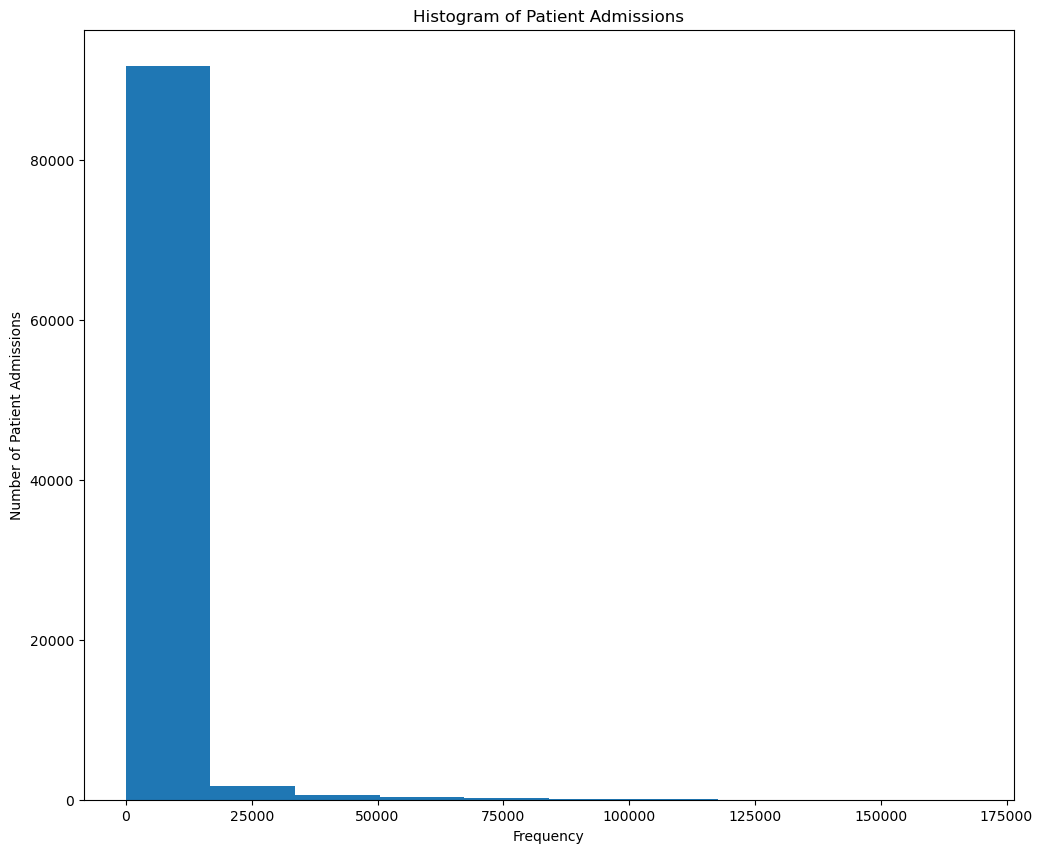

In [33]:
#Histogram of patient admissions numbers
plt.figure(figsize=(12, 10))
plt.hist(data=df, x='Number of patient admissions')
plt.ylabel('Number of Patient Admissions')
plt.xlabel('Frequency')
plt.title('Histogram of Patient Admissions')
plt.show();

In [34]:
#remove outliers in admissions numbers 

In [35]:
# Calculate Q1 (25th percentile) and Q3 (75th percentile)
Q1 = df['Number of patient admissions'].quantile(0.25)
Q3 = df['Number of patient admissions'].quantile(0.75)

# Calculate the IQR
IQR = Q3 - Q1

# Define the outlier bounds
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filter out the outliers
df_filtered = df[(df['Number of patient admissions'] >= lower_bound) & 
                 (df['Number of patient admissions'] <= upper_bound)]

print("Data after removing outliers:")
print(df_filtered)

Data after removing outliers:
                                  Reporting unit Reporting unit type State  \
0       Adolescent and Young Adult Hospice Manly            Hospital   NSW   
1       Adolescent and Young Adult Hospice Manly            Hospital   NSW   
3       Adolescent and Young Adult Hospice Manly            Hospital   NSW   
4       Adolescent and Young Adult Hospice Manly            Hospital   NSW   
5       Adolescent and Young Adult Hospice Manly            Hospital   NSW   
...                                          ...                 ...   ...   
103058           University of Canberra Hospital            Hospital   ACT   
103059           University of Canberra Hospital            Hospital   ACT   
103061           University of Canberra Hospital            Hospital   ACT   
103065           University of Canberra Hospital            Hospital   ACT   
103066           University of Canberra Hospital            Hospital   ACT   

       Time period               

In [36]:
len(df_filtered)

79396

In [37]:
94747 - 79396

15351

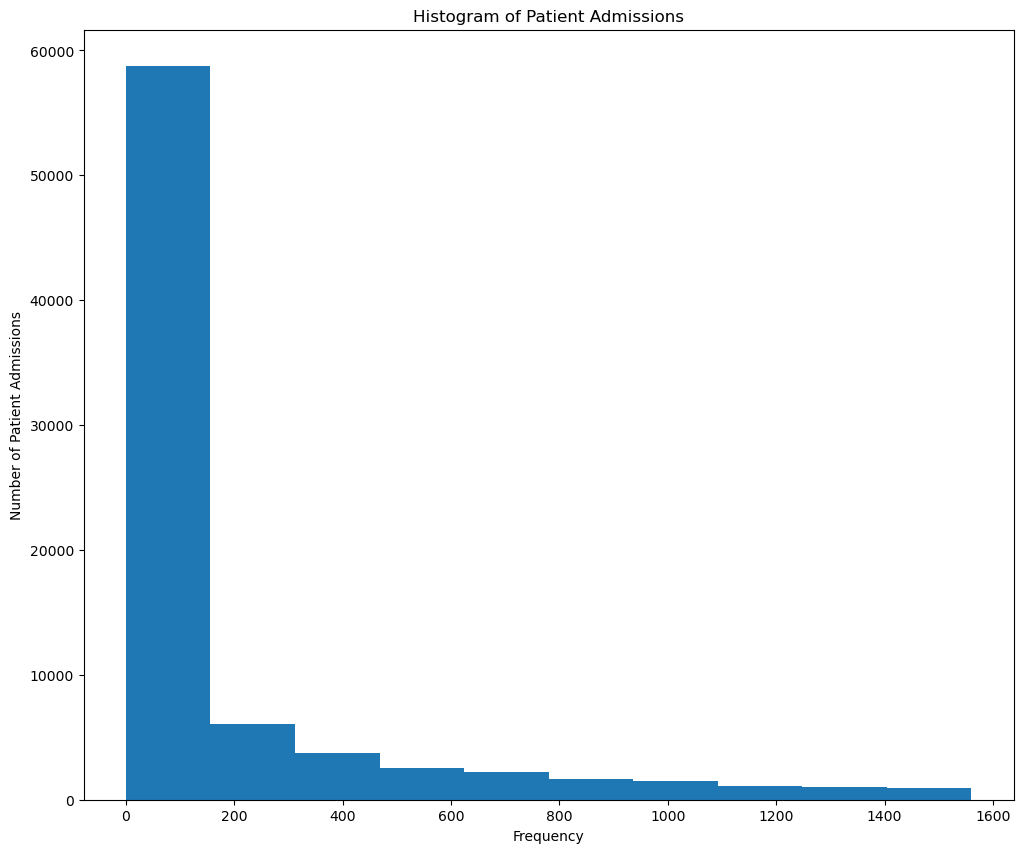

In [38]:
plt.figure(figsize=(12, 10))
plt.hist(data=df_filtered, x='Number of patient admissions')
plt.ylabel('Number of Patient Admissions')
plt.xlabel('Frequency')
plt.title('Histogram of Patient Admissions')
plt.show();

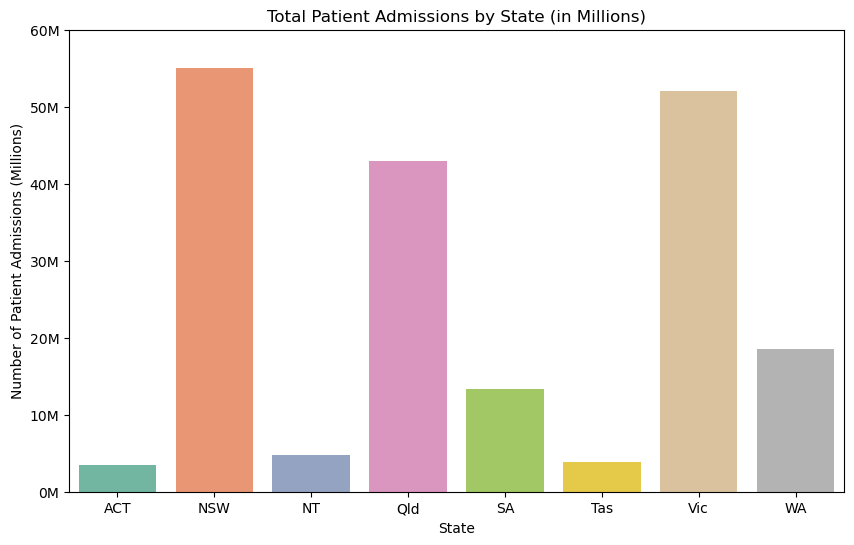

In [130]:
#now let's look at the number of patient admissions by state:

# Group by State and sum admissions
state_admissions = df.groupby('State')['Number of patient admissions'].sum().reset_index()

colors = ['#66c2a5', '#fc8d62', '#8da0cb', '#e78ac3', '#a6d854', 
          '#ffd92f', '#e5c494', '#b3b3b3', '#a6cee3', '#1f78b4', '#33a02c']

# Create bar plot using Seaborn
plt.figure(figsize=(10, 6))
sns.barplot(x='State', y='Number of patient admissions', data=state_admissions, palette=colors)

# Set y-axis tick locations (manually set based on data range)
y_ticks = plt.gca().get_yticks()  # Get the current ticks
plt.gca().set_yticks(y_ticks)  # Set the ticks explicitly

# Format y-axis ticks (convert to millions)
plt.gca().set_yticklabels(['{:.0f}M'.format(y/1e6) for y in y_ticks])

# Customize plot
plt.title('Total Patient Admissions by State (in Millions)')
plt.xlabel('State')
plt.ylabel('Number of Patient Admissions (Millions)')

# Show plot
plt.show();

In [40]:
#we can clearly see that NSW has the highest number of patient admissions, followed by Vic

In [41]:
#create a stacked bar plot showing the breakdown of hospital admissions by Category for each State

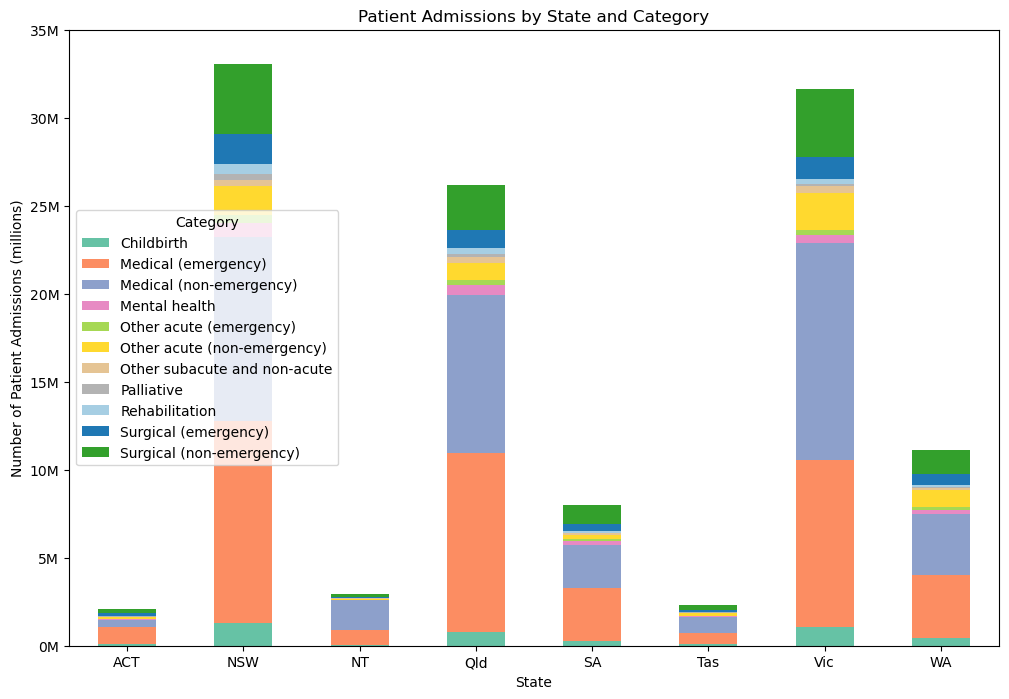

In [122]:
df_filtered = df[df['Category'] != 'Total']

# Pivot the data to get a table with States as rows and Categories as columns
pivot_df = df_filtered.pivot_table(values='Number of patient admissions', 
                                   index='State', 
                                   columns='Category', 
                                   aggfunc='sum').fillna(0)

colors = ['#66c2a5', '#fc8d62', '#8da0cb', '#e78ac3', '#a6d854', 
          '#ffd92f', '#e5c494', '#b3b3b3', '#a6cee3', '#1f78b4', '#33a02c']

# Plot Stacked Bar Chart
pivot_df.plot(kind='bar', stacked=True, figsize=(12, 8), color=colors)

# Set y-axis tick locations (manually set based on data range)
y_ticks = plt.gca().get_yticks()  # Get the current ticks
plt.gca().set_yticks(y_ticks)  # Set the ticks explicitly

# Format y-axis ticks (convert to millions)
plt.gca().set_yticklabels(['{:.0f}M'.format(y/1e6) for y in y_ticks])

# Customize the plot
plt.title('Patient Admissions by State and Category')
plt.xlabel('State')
plt.ylabel('Number of Patient Admissions (millions)')
plt.xticks(rotation=0)  # Keep the x-axis labels horizontal for readability
plt.legend(title='Category')

# Show plot
plt.show();

In [43]:
#Just by looking at this stacked bar chart, it is interesting to note that the number of emergency and non-emergency admissions in the medical category are pretty even across the states. 

In [44]:
#create a line plot showing the trends in patient admissions over the Time Period

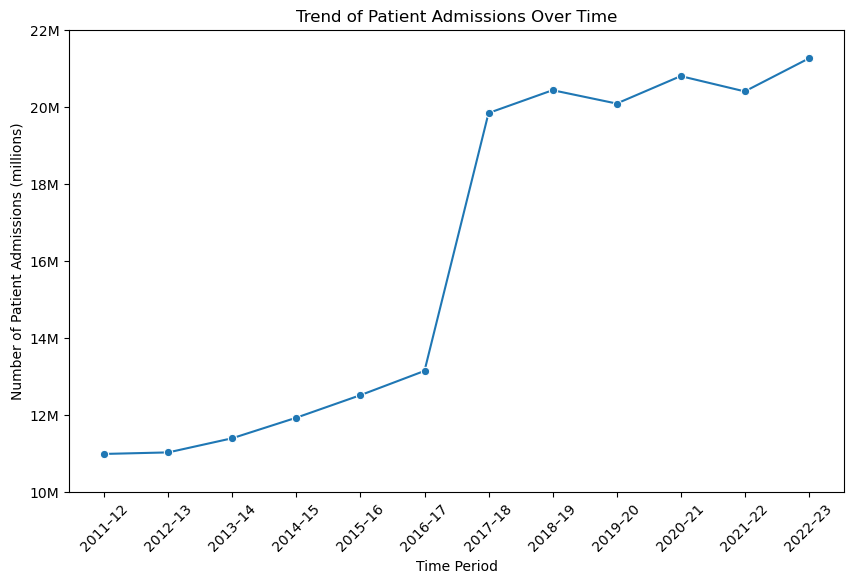

In [45]:
# Group by Time Period and sum admissions
time_trend = df.groupby('Time period')['Number of patient admissions'].sum().reset_index()

# Sort by Time Period 
time_trend = time_trend.sort_values('Time period')

# Create line plot
plt.figure(figsize=(10, 6))
sns.lineplot(x='Time period', y='Number of patient admissions', data=time_trend, marker='o')

# Set y-axis tick locations (manually set based on data range)
y_ticks = plt.gca().get_yticks()  # Get the current ticks
plt.gca().set_yticks(y_ticks)  # Set the ticks explicitly

# Format y-axis ticks (convert to millions)
plt.gca().set_yticklabels(['{:.0f}M'.format(y/1e6) for y in y_ticks])

# Customize plot
plt.title('Trend of Patient Admissions Over Time')
plt.xlabel('Time Period')
plt.ylabel('Number of Patient Admissions (millions)')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability

# Show plot
plt.show();


In [46]:
#What happened in 2017 that caused a big increase in the amount of patient admissions?

In [47]:
# create a heatmap showing the relationship between State and Time Period for patient admissions

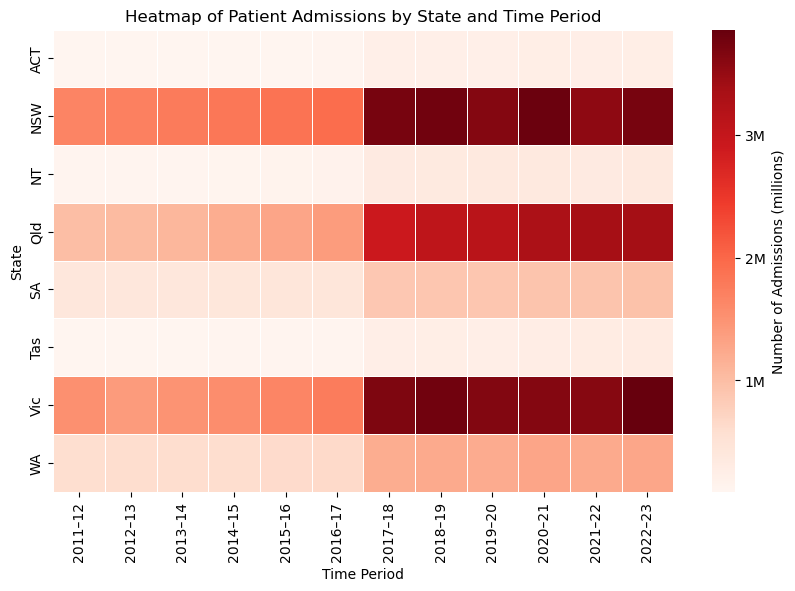

In [150]:
# Pivot the data to have States as rows, Time Periods as columns, and Admissions as values
heatmap_data = df_filtered.pivot_table(values='Number of patient admissions', 
                              index='State', 
                              columns='Time period', 
                              aggfunc='sum').fillna(0)

# Create the heatmap
plt.figure(figsize=(10, 6))

heatmap = sns.heatmap(heatmap_data, annot=False, fmt=".0f", cmap="Reds", linewidths=.5,
                       cbar_kws={'label': 'Number of Admissions (millions)', 'ticks': [1e6, 2e6, 3e6, 4e6, 5e6]})

colorbar = heatmap.collections[0].colorbar
colorbar.set_ticks([1e6, 2e6, 3e6])  # Set the positions of the ticks
colorbar.set_ticklabels(['1M', '2M', '3M'])

# Customize the plot
plt.title('Heatmap of Patient Admissions by State and Time Period')
plt.xlabel('Time Period')
plt.ylabel('State')

# Show plot
plt.show();

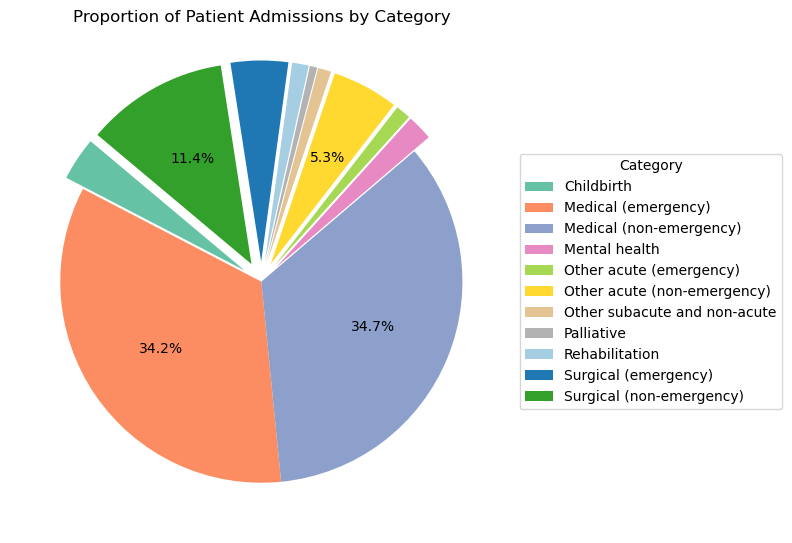

In [116]:
category_admissions = df_filtered.groupby('Category')['Number of patient admissions'].sum()

# Define specific colors for each category
colors = ['#66c2a5', '#fc8d62', '#8da0cb', '#e78ac3', '#a6d854', 
          '#ffd92f', '#e5c494', '#b3b3b3', '#a6cee3', '#1f78b4', '#33a02c'][:len(category_admissions)]

# Define explode values to separate smaller slices if needed
explode = [0.1 if val < category_admissions.sum() * 0.2 else 0 for val in category_admissions]

def autopct_format(pct):
    return f'{pct:.1f}%' if pct >= 5 else ''



# Create Pie Chart without labels
plt.figure(figsize=(8, 8))
plt.pie(category_admissions, 
        autopct=autopct_format, 
        startangle=140, 
        explode=explode, 
        colors=colors)

# Add a legend outside the pie chart for readability
plt.legend(category_admissions.index, title="Category", bbox_to_anchor=(1, 0.5), loc="center left")

# Customize plot
plt.title('Proportion of Patient Admissions by Category')

# Show plot
plt.tight_layout()  # Adjust layout to make room for legend
plt.show();